# 558 Homework 3
#### Anushna Prakash
#### April 25, 2021

$$\begin{equation}
F(\beta) = \frac{1}{n} \sum_{i=1}^n log(1 + e^{-y_i x_i^T \beta}) + \lambda ||\beta||_2^2
\end{equation}
$$

Assume the case where $n=1$ and $d=1$. Then:
$$
F(\beta) = log(1 + e^{-y_{i} x_{i}^T \beta}) + \lambda \beta^2
\\ \nabla F(\beta) = \frac{-yx e^{-yx\beta}}{1 + e^{-yx \beta}} + 2\lambda \beta
$$

Now assuming the case where $n>1$ and $d>1$, and $y$ is $1xn$, $x$ is $dxn$ and $\beta$ is $dx1$:
$$
\nabla F(\beta) = \frac{1}{n} \frac{-y^T x e^{-y x^T \beta}}{1 + e^{-y x^T \beta}} + 2 \lambda \beta 
$$

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [3]:
file = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv(file, sep = ',', header = 0, index_col = 0)
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [30]:
X = smarket[['Lag1', 'Lag2', 'Volume']].to_numpy()
# y = {1, -1} for {Up, Down}
y = smarket['Direction'].apply(lambda x: 1 if (x == 'Up') else -1).to_numpy()
print(X.shape)
print(y.shape)
X_train_us, X_test_us, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

(1250, 3)
(1250,)


In [31]:
# Standardize train and test sets on training data
X_ss = StandardScaler().fit(X_train_us)
X_train = X_ss.transform(X_train_us)
X_test = X_ss.transform(X_test_us)

In [51]:
def computegrad(beta, X, y, lambda_):
    """
    Returns the gradient for regularized logistic regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    grad : 1D array
        A numpy array of the gradient with the given X, y, and lambda with shape 1 x d
    """
    n = X.shape[0]
    Q = np.diag(np.exp(np.multiply(-y, X @ beta)) / (np.exp(np.multiply(-y, X @ beta)) + 1))
#     print(Q)
#     Debugging print statements
#     print("n: ", n)
#     print("x_tb: ", x_tb.shape)
#     print("e_: ", e_.shape)
#     print("numerator: ", (-y @ X).shape)
    return (-1/n) * (X.T @ Q @ y)  + 2 * lambda_ * beta

In [48]:
lambda_ = 0.5
beta = np.ones(X.shape[1])
computegrad(beta, X_train, y_train, lambda_)

[[0.5406785  0.         0.         ... 0.         0.         0.        ]
 [0.         0.00988306 0.         ... 0.         0.         0.        ]
 [0.         0.         0.41342513 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.35075992 0.         0.        ]
 [0.         0.         0.         ... 0.         0.12355645 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16387013]]


array([1.17269495, 1.16353943, 1.1437125 ])

In [67]:
def computeobj(beta, X, y, lambda_):
    """
    Returns the gradient for regularized logistic regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    obj : float
        Value of the objective function evaluated with the given parameters
    """
    n = X.shape[1]
    e_ = np.exp(-y @ X @ beta)
    return (1/n) * np.sum(np.log(1 + e_)) + lambda_ * np.linalg.norm(beta)**2

In [9]:
def backtracking(eta_init, decay_rate, prop, p, beta, *args):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    p : 1D array
        A numpy array with shape 1 x d representing the direction
    beta : 1D array
        A numpy array with shape 1 x d
    *args : X, y, lambda_
    
    Returns
    -------
    eta : float
        Optimal size of eta for fast gradient descent
    """
    eta = eta_init
    
    def decrease_condition(eta):
        """
        Compute if the difference in objective functions evaluated with new vs. old beta
        is less than ???
        """
        left = computeobj(beta + eta * p, *args) - computeobj(beta, *args)
        right = eta * prop * np.dot(computegrad(beta, *args), p)
        return left <= right
    
    while not decrease_condition(eta):
        eta *= decay_rate
    
    return eta

In [75]:
def graddescent(tolerance, eta_init, decay_rate, prop, beta_init, *args):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    tolerance: float
        A total error tolerance
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    beta_init : 1D array
        A numpy array with shape 1 x d
    *args : X, y, lambda_
    
    Returns
    -------
    iterations : list
        List of betas with most optimal beta being at [-1] index
    """
    iterations = [beta_init]
    grad = computegrad(beta_init, *args)
    beta = beta_init
    
    while np.linalg.norm(grad) > tolerance:
        p = -grad
        eta = backtracking(eta_init, decay_rate, prop, p, beta, *args)
        beta = beta - eta * computegrad(beta, *args)
        grad = computegrad(beta, *args)
        iterations.append(beta)
    
    return iterations

In [76]:
def fastgradalgo(tolerance, eta_init, decay_rate, prop, X, y, lambda_):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    tolerance: float
        A total error tolerance
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    num_features : int
        Number of features in data set
    *args : X, y, lambda_
    
    Returns
    -------
    iterations : list
        List of betas with most optimal beta being at [-1] index
    """
    beta = np.zeros(X.shape[1])
    theta = np.zeros(X.shape[1])
    iterations = [beta]
    grad = computegrad(beta, X, y, lambda_)
    t = 0
    
    while np.linalg.norm(grad) > tolerance:
        p = -grad
        eta = backtracking(eta_init, decay_rate, prop, p, beta, X, y, lambda_)
        beta_t = theta - eta * computegrad(theta, X, y, lambda_)
        theta = beta_t + (t / (t + 3)) * (beta_t - beta)
        grad = computegrad(beta_t, X, y, lambda_)
        beta = beta_t
        t += 1
        iterations.append(beta)
    
    return iterations

In [12]:
import matplotlib.pyplot as plt

In [61]:
# Initialize parameters
eta_init = 0.1
error = 5e-4
lambda_ = 0.5
decay_rate = 0.8
prop = 0.3
beta_init = np.zeros(X.shape[1])

In [68]:
grad_descent = graddescent(error, eta_init, decay_rate, prop, beta_init, X_train, y_train, lambda_)
f_slow = [computeobj(b, X_train, y_train, lambda_) for b in grad_descent]
fast_grad_descent = fastgradalgo(error, eta_init, decay_rate, prop, X_train, y_train, lambda_)
f_fast = [computeobj(b, X_train, y_train, lambda_) for b in fast_grad_descent]

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


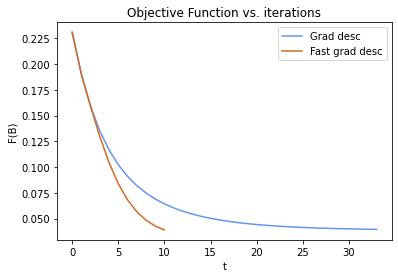

In [69]:
plt.plot(f_slow, c = 'cornflowerblue')
plt.plot(f_fast, c = 'chocolate')
plt.title('Objective Function vs. iterations')
plt.xlabel('t')
plt.ylabel('F(B)')
plt.legend(['Grad desc', 'Fast grad desc'])

In [26]:
# Compare accuracy
lambda_ = 0.5
beta = grad_descent[-1]
prob = np.exp(np.dot(X_train, beta)) / (np.exp(np.dot(X_train, beta)) + 1)
prediction = np.zeros(len(prob))

for i in range(len(prob)):
    if prob[i] > 0.5:
        prediction[i] = 1
    else:
        prediction[i] = -1

print(prob)
print(prediction)

[0.50231662 0.49971992 0.50416111 0.50200638 0.50020508 0.49761474
 0.49835881 0.49810419 0.49653875 0.50296801 0.49416889 0.50506976
 0.50095118 0.49953436 0.50309495 0.49728731 0.49949219 0.49551254
 0.50021329 0.49913095 0.49985537 0.50151999 0.49935607 0.49830283
 0.49246933 0.50129432 0.49952237 0.50191246 0.49010663 0.51861057
 0.49804669 0.49906276 0.49541947 0.49269057 0.49966277 0.49714455
 0.49917924 0.50176714 0.49859674 0.49816373 0.50342986 0.50321184
 0.5035645  0.49727156 0.49578551 0.50654641 0.50006688 0.49883012
 0.49435391 0.50133565 0.49644823 0.50422306 0.50257153 0.50120821
 0.4982109  0.50017202 0.50125193 0.49950071 0.49741022 0.49728228
 0.50471706 0.49969585 0.4889414  0.49895115 0.50685885 0.49660201
 0.50407824 0.49865978 0.50190959 0.50266198 0.5003767  0.50209877
 0.49948596 0.50153263 0.50241216 0.49306694 0.49617085 0.49862444
 0.50345969 0.49021462 0.50168358 0.49552801 0.50293986 0.49635767
 0.48504803 0.49990285 0.50024077 0.50525631 0.49619076 0.4930

In [ ]:
train_performance = pd.crosstab(y_train, prediction, rownames = ['Truth'], colnames = ['Predictions'])
train_performance

In [ ]:
tn = train_performance.iloc[0, 0]
tp = train_performance.iloc[1, 1]
fn = train_performance.iloc[1, 0]
fp = train_performance.iloc[0, 1]

In [ ]:
print("Accuracy: ", (tp + tn) / (tp + tn + fn + fp))
print("Misclassification: ", (fp + fn) / (tp + tn + fn + fp))

`sklearn`'s Regularized Logistic Regression minimizes the function
$$ \begin{equation}
F(\beta) = \frac{1}{2} \beta^{T} \beta + C \sum_{i = 1}^{n} log(-y_{i}(X_{i}^T \beta + c)+1)
\end{equation}$$

The $C$ hyperparameter corresponds with $\lambda = \frac{1}{2nC}$, or $C = 2n\lambda$

In [70]:
lambda_ = 0.5
n = X_train.shape[0]
c = lambda_ * n * 2
b_t = fast_grad_descent[-1]
sk_logistic = LogisticRegression(penalty = 'l2',
                                 tol = error,
                                 C = c,
                                 fit_intercept = False).fit(X_train, y_train)
b_star = sk_logistic.coef_.ravel()

In [71]:
print('Beta_T - Beta*: ', (b_t - b_star))
f_t = computeobj(b_t, X_train, y_train, lambda_)
f_star = computeobj(b_star, X_train, y_train, lambda_)
print("F(B_T): ", f_t)
print("F(B*): ", f_star)

Beta_T - Beta*:  [ 0.06615578  0.05455137 -0.08501572]
F(B_T):  0.03894608170536094
F(B*):  0.011210567474149054


`sklearn`'s implementation produced a lower objective function value compared to my implementation of fast gradient descent.

In [73]:
log_cv = LogisticRegressionCV(penalty = 'l2').fit(X_train, y_train).C_
opt_lambda = log_cv[0] / (2 * n)
log_cv[0]

0.005994842503189409

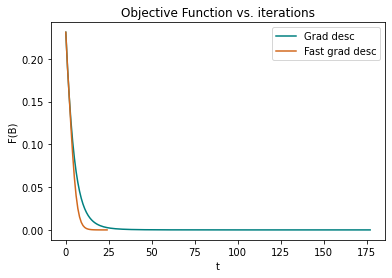

In [77]:
# Initialize parameters
eta_init = 0.1
error = 5e-4
decay_rate = 0.8
prop = 0.3
beta_init = np.zeros(X.shape[1])

grad_descent = graddescent(error, eta_init, decay_rate, prop, beta_init, X_train, y_train, opt_lambda)
f_slow = [computeobj(b, X_train, y_train, opt_lambda) for b in grad_descent]
fast_grad_descent = fastgradalgo(error, eta_init, decay_rate, prop, X_train, y_train, opt_lambda)
f_fast = [computeobj(b, X_train, y_train, opt_lambda) for b in fast_grad_descent]

plt.plot(f_slow, c = 'teal')
plt.plot(f_fast, c = 'chocolate')
plt.title('Objective Function vs. iterations')
plt.xlabel('t')
plt.ylabel('F(B)')
plt.legend(['Grad desc', 'Fast grad desc'])

In [87]:
def misclass_rate(beta, X, y):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    beta : 1D array
        A 1xd numpy array
    X : ndarray
        A n x d numpy array of feature data
    y : 1D array
        A 1 x n numpy array of correct response data
    
    Returns
    -------
    misclass : float
        Misclassification rate
    """
    prob = np.exp(np.dot(X, beta)) / (np.exp(np.dot(X, beta)) + 1)
    prediction = np.zeros(len(prob))

    for i in range(len(prob)):
        if prob[i] >= 0.5:
            prediction[i] = 1
        else:
            prediction[i] = -1
    
    train_performance = pd.crosstab(y, prediction, rownames = ['Truth'], colnames = ['Pred'])
    try:
        fp = train_performance.iloc[0, 1]
    except IndexError:
        fp = 0
    
    try:
        fn = train_performance.iloc[1, 0]
    except IndexError:
        fn = 0
        
    misclass = (fp + fn) / len(y)
    
    return misclass

In [88]:
misclass_slow = [misclass_rate(b, X_train, y_train) for b in grad_descent]
misclass_fast = [misclass_rate(b, X_train, y_train) for b in fast_grad_descent]

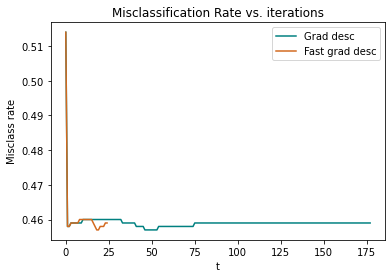

In [89]:
plt.plot(misclass_slow, c = 'teal')
plt.plot(misclass_fast, c = 'chocolate')
plt.title('Misclassification Rate vs. iterations')
plt.xlabel('t')
plt.ylabel('Misclass rate')
plt.legend(['Grad desc', 'Fast grad desc'])